Imports Tools and Libraries

In [5]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

Image Captioning
What is Image Captioning ?

Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.
CNNs + RNNs (LSTMs)

To perform Image Captioning we will require two deep learning models combined into one for the training purpose
CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
For a more illustrative explanation of this architecture check the Modelling section for a picture representation

Load Dataset

In [6]:
import pandas as pd

# Path to your dataset
image_path = "/content/drive/MyDrive/NLP_dataset/Images"
data = pd.read_csv("/content/drive/MyDrive/NLP_dataset/captions.txt")

print(data.head())


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


Visualization
Images and their corresponding captions

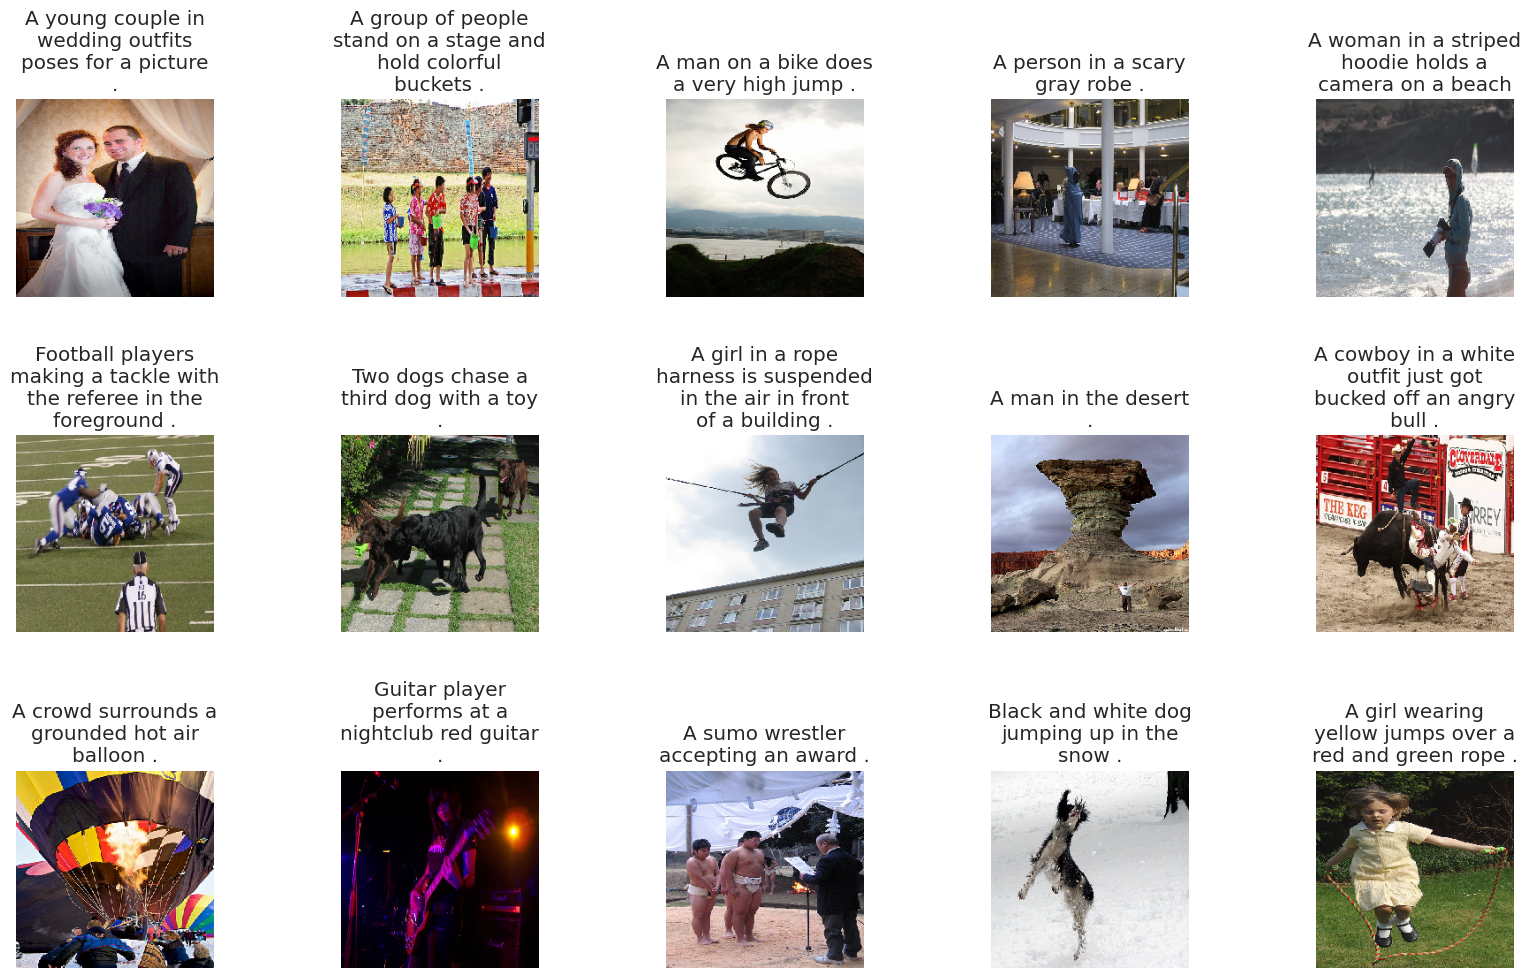

In [7]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from textwrap import wrap
import os

def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img

def display_images(temp_df, base_path, n_images=15):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))

    for i in range(n_images):
        image_path = os.path.join(base_path, temp_df.image[i])  # ✅ correct path for Colab

        if not os.path.exists(image_path):   # ✅ Skip missing files safely
            print(f"Missing: {image_path}")
            continue

        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        image = readImage(image_path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

    plt.show()

# Example usage
base_path = "/content/drive/MyDrive/NLP_dataset/Images"  # 👈 change if your folder is different
display_images(data.sample(15), base_path)


Caption Text Preprocessing Steps

Convert sentences into lowercase
Remove special characters and numbers present in the text
Remove extra spaces
Remove single characters
Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [8]:
import re
import pandas as pd

def text_preprocessing(data):
    # lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())

    # remove non-alphabet characters
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"[^a-z]", " ", x))

    # remove extra spaces
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"\s+", " ", x).strip())

    # remove single-character words
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))

    # add start and end tokens
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x + " endseq")

    return data

# Example usage
# (Assuming your dataframe `data` is already loaded with columns: ['image', 'caption'])
data = text_preprocessing(data)

captions = data['caption'].tolist()
print(captions[:10])


['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


Tokenization and Encoded Representation

The words in a sentence are separated/tokenized and encoded in a one hot representation
These encodings are then passed to the embeddings layer to generate word embeddings


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer


# 1. Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# 2. Vocabulary size (add +1 for padding index = 0)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

# 3. Max caption length
max_length = max(len(caption.split()) for caption in captions)
print("Max caption length:", max_length)

# 4. Unique images
images = data['image'].unique().tolist()
nimages = len(images)
print("Total images:", nimages)

# 5. Train-validation split (85-15%)
split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# 6. Create train/test DataFrames
train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(val_images)].reset_index(drop=True)

print("Training samples:", train.shape)
print("Validation samples:", test.shape)

# 7. Test tokenization
sample_seq = tokenizer.texts_to_sequences([captions[1]])[0]
print("Sample caption:", captions[1])
print("Tokenized:", sample_seq)


Vocabulary size: 8427
Max caption length: 35
Total images: 8091
Training samples: (34385, 2)
Validation samples: (6070, 2)
Sample caption: startseq girl going into wooden building endseq
Tokenized: [1, 18, 313, 63, 194, 116, 2]


Image Feature Extraction

DenseNet 201 Architecture is used to extract the features from the images
Any other pretrained architecture can also be used for extracting features from these images
Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

In [ ]:
# ------------------ Step 6: Image Feature Extraction ------------------
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load DenseNet201 pretrained on ImageNet
base_model = DenseNet201(weights="imagenet", include_top=True)

# Use the second-last layer (Global Average Pooling) as feature extractor
fe = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

img_size = 224
features = {}

# Loop through each unique image in the dataset
for image in tqdm(data['image'].unique().tolist()):
    img_path = os.path.join(image_path, image)

    if not os.path.exists(img_path):   # ✅ handle missing images safely
        print(f"⚠️ Missing: {img_path}")
        continue

    # Preprocess image
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Extract features
    feature = fe.predict(img, verbose=0)

    # Save features in dictionary
    features[image] = feature

print("\n✅ Feature extraction complete!")
print("Total images processed:", len(features))
print("Example feature shape:", list(features.values())[0].shape)


100%|██████████| 8091/8091 [1:10:56<00:00,  1.90it/s]


✅ Feature extraction complete!
Total images processed: 8091
Example feature shape: (1, 1920)


Data Generation

Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
The text embeddings are passed word by word for the caption generation during inference time

In [ ]:
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].unique().tolist()

        for image in images:
            if image not in self.features:
                continue  # skip missing features

            feature = self.features[image][0]  # Step 6 features
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y


# Create generators
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64,
                                      tokenizer=tokenizer, vocab_size=vocab_size,
                                      max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64,
                                           tokenizer=tokenizer, vocab_size=vocab_size,
                                           max_length=max_length, features=features)

# Test first batch
train_batch = train_generator[0]
print("Shapes - Image features:", train_batch[0][0].shape, "Sequences:", train_batch[0][1].shape, "Targets:", train_batch[1].shape)


: 

Modelling

The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
The LSTM network starts generating words after each input thus forming a sentence at the end

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Reshape, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Inputs ---
input1 = Input(shape=(1920,), name="image_input")        # Image feature vector from DenseNet201
input2 = Input(shape=(max_length,), name="sequence_input")  # Tokenized caption sequence

# --- Image feature processing ---
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)  # reshape to (batch, 1, 256)

# --- Text feature processing ---
# mask_zero=False to prevent dtype conflict during concatenation
sentence_features = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=False)(input2)

# --- Merge image and text features ---
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# --- LSTM to process the merged sequence ---
lstm_out = LSTM(256)(merged)

# --- Fully connected layers with residual connection ---
x = Dropout(0.5)(lstm_out)
x = add([x, img_features])  # add residual image features
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# --- Output layer ---
output = Dense(vocab_size, activation='softmax')(x)

# --- Final model ---
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
caption_model.summary()

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    min_lr=1e-8,
    verbose=1
)

# --- Train the model ---
history = caption_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, earlystopping, lr_reduction]
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    491,776 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_input      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 256)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 256)   │  2,157,312 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 36, 256)   │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8427)      │  1,087,083 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,294,379 (16.38 MB)

 Trainable params: 4,294,379 (16.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 5.7106
Epoch 1: val_loss improved from inf to 4.31024, saving model to best_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 85s 150ms/step - loss: 5.7095 - val_loss: 4.3102 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.3590
Epoch 2: val_loss improved from 4.31024 to 3.98766, saving model to best_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - loss: 4.3588 - val_loss: 3.9877 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 4.0571
Epoch 3: val_loss improved from 3.98766 to 3.83014, saving model to best_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - loss: 4.0570 - val_loss: 3.8301 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 3.8718
Epoch 4: val_loss improved from 3.83014 to 3.74254, saving model to best_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - loss: 3.8718 - val_loss: 3.7425 - le

Learning Curve

The model has clearly overfit, possibly due to less amount of data
We can tackle this problem in two ways
Train the model on a larger dataset Flickr40k
Attention Models

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 2000x800 with 0 Axes>

Caption Generation Utility Functions

Utility functions to generate the captions of input images at the inference time.
Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [ ]:
# Save trained captioning model
caption_model.save("model.keras")

# Save feature extractor
fe.save("feature_extractor.keras")

# Save tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Load trained captioning model
caption_model = load_model("model.keras")

# Load feature extractor
fe = load_model("feature_extractor.keras")

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption_and_show_image(image_path, model, feature_extractor, tokenizer, img_size=224):
    # Load image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features
    image_features = feature_extractor.predict(img_array, verbose=0)

    # Get the model's expected sequence length
    max_length = model.input_shape[1][1]  # Fix: Access the sequence length from the tuple

    # Generate caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict next word probabilities
        yhat = model.predict([image_features, sequence], verbose=0)[0]
        yhat_index = np.argmax(yhat)  # Use argmax for deterministic caption
        word = tokenizer.index_word.get(yhat_index, None)

        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Print the caption separately
    print("Generated Caption:", caption)

    return caption

In [4]:
# List of image paths
image_list = [

    "/content/drive/MyDrive/NLP_dataset/Copy of 1000268201_693b08cb0e.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1001773457_577c3a7d70.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1002674143_1b742ab4b8.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1007129816_e794419615.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1009434119_febe49276a.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1012212859_01547e3f17.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1015584366_dfcec3c85a.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 106490881_5a2dd9b7bd.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 106490881_5a2dd9b7bd.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1067790824_f3cc97239b.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1072153132_53d2bb1b60.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 107318069_e9f2ef32de.jpg",
    "/content/drive/MyDrive/NLP_dataset/Copy of 1096097967_ac305887b4.jpg"

]

# Loop through each image
for img_path in image_list:
    print(f"\nProcessing Image: {img_path.split('/')[-1]}")
    caption = generate_caption_and_show_image(img_path, caption_model, feature_extractor, tokenizer)



Processing Image: Copy of 1000268201_693b08cb0e.jpg


NameError: name 'caption_model' is not defined